## Loading the CIFAR-10 dataset

In [31]:
#Image Classification
import os
from urllib.request import urlretrieve
#from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import unittest
path = "C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment"
os.chdir(path)
os.getcwd() 



'C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment'

## Data analysis and preprocessing

In [32]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf

In [33]:
# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [34]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [35]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


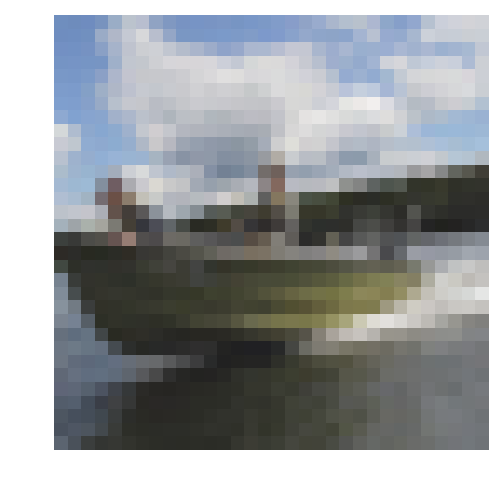

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

path = "C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment\\cifar-10-batches-py\\"
os.chdir(path)


# Explore a specific batch and sample from the dataset
cifar10_dataset_folder_path = path
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

path = "C:\\Users\\HP\\Desktop\\Learning\\DataScience\\01Materials\\38. DEEP LEARNING 5 PROJECT-6 IMPLEMENTATION - IMAGE CLASSIFICATION\\Assignment\\cifar-10-batches-py\\"
os.chdir(path)


# Explore a specific batch and sample from the dataset
cifar10_dataset_folder_path = path
batch_id = 2
sample_id = 4
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

#### Apply normalization and 1-hot encoding to dataset

In [37]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [38]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [39]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [40]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklear

In [41]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Model Building

In [42]:
# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [43]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [44]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [45]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [46]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [47]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [48]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [49]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [50]:
test_conv_net(build_convolution_net)

Neural Network Built!


## Training Model

In [51]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [52]:
#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [53]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [54]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [55]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 2144.067383
Valid accuracy: 0.101562
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1639.745239
Valid accuracy: 0.085938
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1955.252441
Valid accuracy: 0.070312
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1634.452393
Valid accuracy: 0.062500
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1186.950317
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1344.348633
Valid accuracy: 0.148438
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1202.625977
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1238.468262
Valid accuracy: 0.109375
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1063.344360
Valid accuracy: 0.171875
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 881.647888
Valid accuracy: 0.179688
Epoch number  1, CIFAR-10 Batc

Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 243.393372
Valid accuracy: 0.257812
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 227.709076
Valid accuracy: 0.273438
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 220.374268
Valid accuracy: 0.242188
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 202.582977
Valid accuracy: 0.343750
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 224.444016
Valid accuracy: 0.367188
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 235.219879
Valid accuracy: 0.296875
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 226.117493
Valid accuracy: 0.312500
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 204.268433
Valid accuracy: 0.304688
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 229.622528
Valid accuracy: 0.320312
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 205.786957
Valid accuracy: 0.359375
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 230.559418
Valid accuracy: 0.312500
Epoch numb

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 153.794220
Valid accuracy: 0.242188
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 145.690155
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 138.043488
Valid accuracy: 0.421875
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 123.355827
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 129.710388
Valid accuracy: 0.406250
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 106.750198
Valid accuracy: 0.414062
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 125.490738
Valid accuracy: 0.406250
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 106.790329
Valid accuracy: 0.382812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 139.925781
Valid accuracy: 0.312500
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 113.130211
Valid accuracy: 0.398438
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 106.130951
Valid accuracy: 0.437500
Epoch numb

Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 84.139351
Valid accuracy: 0.398438
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 82.130302
Valid accuracy: 0.351562
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 86.865906
Valid accuracy: 0.398438
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 67.223244
Valid accuracy: 0.476562
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 71.812119
Valid accuracy: 0.445312
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 66.597000
Valid accuracy: 0.476562
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 63.899902
Valid accuracy: 0.414062
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 81.424347
Valid accuracy: 0.398438
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 77.351303
Valid accuracy: 0.414062
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 77.769547
Valid accuracy: 0.445312
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 81.324120
Valid accuracy: 0.429688
Epoch number  4, CIFA

Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 58.383434
Valid accuracy: 0.468750
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 47.259811
Valid accuracy: 0.515625
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 58.103596
Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 62.245899
Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 53.293243
Valid accuracy: 0.460938
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 52.232807
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 69.182816
Valid accuracy: 0.421875
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 51.927074
Valid accuracy: 0.445312
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 59.870464
Valid accuracy: 0.476562
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 58.450592
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 60.795498
Valid accuracy: 0.437500
Epoch number  6, CIFA

Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 49.053596
Valid accuracy: 0.390625
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 46.619545
Valid accuracy: 0.468750
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 46.520546
Valid accuracy: 0.437500
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 34.711655
Valid accuracy: 0.460938
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 46.264084
Valid accuracy: 0.484375
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 54.187763
Valid accuracy: 0.406250
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 48.416504
Valid accuracy: 0.468750
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 61.224388
Valid accuracy: 0.437500
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 64.329391
Valid accuracy: 0.335938
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 51.130882
Valid accuracy: 0.359375
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 55.660000
Valid accuracy: 0.414062
Epoch number  7, CIFA

Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 36.418690
Valid accuracy: 0.351562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 33.791527
Valid accuracy: 0.476562
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.309658
Valid accuracy: 0.398438
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 25.720970
Valid accuracy: 0.507812
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 40.113106
Valid accuracy: 0.429688
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 33.037621
Valid accuracy: 0.515625
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 31.910975
Valid accuracy: 0.437500
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 31.018873
Valid accuracy: 0.500000
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.413559
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 35.831791
Valid accuracy: 0.375000
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 33.965000
Valid accuracy: 0.468750
Epoch number  8, CIFA

Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 30.289995
Valid accuracy: 0.476562
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 23.822281
Valid accuracy: 0.500000
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 29.590605
Valid accuracy: 0.375000
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 22.341038
Valid accuracy: 0.539062
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 28.106703
Valid accuracy: 0.429688
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 27.427603
Valid accuracy: 0.414062
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 20.224499
Valid accuracy: 0.468750
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 22.115355
Valid accuracy: 0.523438
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 24.813751
Valid accuracy: 0.523438
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 21.626719
Valid accuracy: 0.515625
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 27.695560
Valid accuracy: 0.468750
Epoch number 10, CIFA

Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.600964
Valid accuracy: 0.539062
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 27.152718
Valid accuracy: 0.429688
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.813358
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 26.212099
Valid accuracy: 0.460938
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.960567
Valid accuracy: 0.421875
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 24.742964
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.370075
Valid accuracy: 0.515625
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 23.429329
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 21.100121
Valid accuracy: 0.414062
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.138371
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 24.029163
Valid accuracy: 0.390625
Epoch number 11, CIFA

Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 15.316954
Valid accuracy: 0.492188
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.596194
Valid accuracy: 0.562500
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 14.209114
Valid accuracy: 0.515625
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 13.646266
Valid accuracy: 0.476562
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 15.728695
Valid accuracy: 0.453125
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 17.097216
Valid accuracy: 0.476562
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 15.121345
Valid accuracy: 0.515625
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 18.273380
Valid accuracy: 0.429688
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 16.249163
Valid accuracy: 0.429688
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 15.052328
Valid accuracy: 0.523438
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 20.150230
Valid accuracy: 0.414062
Epoch number 12, CIFA

Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 12.369642
Valid accuracy: 0.507812
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 11.856455
Valid accuracy: 0.507812
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 14.961973
Valid accuracy: 0.460938
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 14.889155
Valid accuracy: 0.421875
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 15.101583
Valid accuracy: 0.460938
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 15.638885
Valid accuracy: 0.460938
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 15.311899
Valid accuracy: 0.550000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 16.269733
Valid accuracy: 0.390625
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 14.940540
Valid accuracy: 0.515625
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 11.346030
Valid accuracy: 0.492188
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 16.399891
Valid accuracy: 0.398438
Epoch number 14, CIFA

Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 8.785723
Valid accuracy: 0.539062
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 12.793991
Valid accuracy: 0.460938
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 9.774885
Valid accuracy: 0.468750
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 11.201222
Valid accuracy: 0.460938
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 9.869909
Valid accuracy: 0.460938
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 10.079948
Valid accuracy: 0.500000
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 10.956737
Valid accuracy: 0.492188
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 9.544037
Valid accuracy: 0.476562
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 9.854189
Valid accuracy: 0.476562
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 14.096613
Valid accuracy: 0.492188
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 11.109280
Valid accuracy: 0.398438
Epoch number 15, CIFAR-10 

Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 10.772371
Valid accuracy: 0.437500
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.132770
Valid accuracy: 0.507812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 11.386539
Valid accuracy: 0.515625
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 10.536963
Valid accuracy: 0.390625
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 10.195247
Valid accuracy: 0.460938
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 11.883059
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.493409
Valid accuracy: 0.507812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 9.684655
Valid accuracy: 0.507812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.039140
Valid accuracy: 0.429688
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.114101
Valid accuracy: 0.492188
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.482494
Valid accuracy: 0.492188
Epoch number 16, CIFAR-10 B

Valid accuracy: 0.531250
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.489860
Valid accuracy: 0.492188
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.644229
Valid accuracy: 0.437500
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.304218
Valid accuracy: 0.390625
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.084851
Valid accuracy: 0.460938
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.515601
Valid accuracy: 0.468750
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.374563
Valid accuracy: 0.484375
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.487345
Valid accuracy: 0.492188
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 5.962244
Valid accuracy: 0.460938
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 6.296251
Valid accuracy: 0.500000
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 8.271648
Valid accuracy: 0.421875
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 7.237330
Valid accuracy: 0.406250
Epoch n

Valid accuracy: 0.484375
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.733140
Valid accuracy: 0.421875
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.990728
Valid accuracy: 0.453125
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.959183
Valid accuracy: 0.476562
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 6.629951
Valid accuracy: 0.460938
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.308903
Valid accuracy: 0.492188
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.844246
Valid accuracy: 0.367188
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.807960
Valid accuracy: 0.523438
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.858917
Valid accuracy: 0.453125
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.828882
Valid accuracy: 0.421875
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 6.725898
Valid accuracy: 0.445312
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 5.949576
Valid accuracy: 0.429688
Epoch n

Valid accuracy: 0.367188
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 4.416528
Valid accuracy: 0.375000
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.328349
Valid accuracy: 0.429688
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 4.668608
Valid accuracy: 0.398438
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.878969
Valid accuracy: 0.406250
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.847500
Valid accuracy: 0.468750
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.738592
Valid accuracy: 0.429688
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 4.291460
Valid accuracy: 0.414062
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 6.655709
Valid accuracy: 0.460938
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 4.736552
Valid accuracy: 0.359375
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.458811
Valid accuracy: 0.429688
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 5.975501
Valid accuracy: 0.390625
Epoch n

Valid accuracy: 0.429688
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 4.409033
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 4.958406
Valid accuracy: 0.367188
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.473450
Valid accuracy: 0.390625
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 5.911312
Valid accuracy: 0.390625
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 5.766812
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.932321
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 4.412672
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.241942
Valid accuracy: 0.367188
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 3.903931
Valid accuracy: 0.421875
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 4.374224
Valid accuracy: 0.492188
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 5.848517
Valid accuracy: 0.406250
Epoch n

Valid accuracy: 0.492188
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.523815
Valid accuracy: 0.414062
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.171565
Valid accuracy: 0.429688
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 4.027032
Valid accuracy: 0.414062
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 4.329406
Valid accuracy: 0.335938
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.839488
Valid accuracy: 0.390625
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.074368
Valid accuracy: 0.437500
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.566740
Valid accuracy: 0.500000
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.693427
Valid accuracy: 0.453125
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 4.007556
Valid accuracy: 0.367188
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.238138
Valid accuracy: 0.468750
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 3.643846
Valid accuracy: 0.367188
Epoch n

Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 4.208490
Valid accuracy: 0.367188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.858941
Valid accuracy: 0.367188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.162548
Valid accuracy: 0.429688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.431162
Valid accuracy: 0.492188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.156841
Valid accuracy: 0.429688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.724115
Valid accuracy: 0.343750
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.806105
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.150015
Valid accuracy: 0.367188
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.664012
Valid accuracy: 0.328125
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 2.710398
Valid accuracy: 0.382812
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 3.460765
Valid accuracy: 0.343750
Epoch n

Valid accuracy: 0.367188
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.653268
Valid accuracy: 0.367188
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 3.002749
Valid accuracy: 0.375000
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.612043
Valid accuracy: 0.406250
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 3.090420
Valid accuracy: 0.453125
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 3.317829
Valid accuracy: 0.328125
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.526779
Valid accuracy: 0.453125
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 3.098073
Valid accuracy: 0.296875
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.359858
Valid accuracy: 0.468750
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 3.576052
Valid accuracy: 0.382812
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 3.615694
Valid accuracy: 0.406250
Epoch number 25, CIFAR-10 Batch Number 1: Valid Loss: 2.540895
Valid accuracy: 0.296875
Epoch n

Valid accuracy: 0.343750
Epoch number 26, CIFAR-10 Batch Number 1: Valid Loss: 2.400784
Valid accuracy: 0.367188
Epoch number 26, CIFAR-10 Batch Number 1: Valid Loss: 1.756634
Valid accuracy: 0.450000
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.534747
Valid accuracy: 0.351562
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 3.431789
Valid accuracy: 0.429688
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.116006
Valid accuracy: 0.429688
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.243383
Valid accuracy: 0.359375
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.102804
Valid accuracy: 0.414062
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.900228
Valid accuracy: 0.421875
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.870334
Valid accuracy: 0.273438
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 2.258645
Valid accuracy: 0.421875
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.842442
Valid accuracy: 0.406250
Epoch n

Valid accuracy: 0.390625
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.405879
Valid accuracy: 0.414062
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.053200
Valid accuracy: 0.406250
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.014148
Valid accuracy: 0.367188
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.822566
Valid accuracy: 0.343750
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.075598
Valid accuracy: 0.375000
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.346193
Valid accuracy: 0.375000
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 1.903593
Valid accuracy: 0.328125
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.191866
Valid accuracy: 0.367188
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.329390
Valid accuracy: 0.468750
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.312863
Valid accuracy: 0.398438
Epoch number 28, CIFAR-10 Batch Number 1: Valid Loss: 2.002955
Valid accuracy: 0.343750
Epoch n

Valid accuracy: 0.406250
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 2.021501
Valid accuracy: 0.359375
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.812237
Valid accuracy: 0.312500
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.909517
Valid accuracy: 0.398438
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.822415
Valid accuracy: 0.382812
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 2.179987
Valid accuracy: 0.406250
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 2.016102
Valid accuracy: 0.320312
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 2.103820
Valid accuracy: 0.343750
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.831915
Valid accuracy: 0.453125
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.885278
Valid accuracy: 0.398438
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 2.038521
Valid accuracy: 0.359375
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.754628
Valid accuracy: 0.398438
Epoch n

Valid accuracy: 0.421875
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.632799
Valid accuracy: 0.437500
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.670112
Valid accuracy: 0.429688
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.955377
Valid accuracy: 0.375000
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.753493
Valid accuracy: 0.445312
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.853831
Valid accuracy: 0.351562
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.723217
Valid accuracy: 0.421875
Epoch number 30, CIFAR-10 Batch Number 1: Valid Loss: 1.612639
Valid accuracy: 0.450000
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.805821
Valid accuracy: 0.367188
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.906877
Valid accuracy: 0.445312
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.639445
Valid accuracy: 0.500000
Epoch number 31, CIFAR-10 Batch Number 1: Valid Loss: 1.746315
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.701330
Valid accuracy: 0.398438
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.598779
Valid accuracy: 0.390625
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.708997
Valid accuracy: 0.390625
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.540676
Valid accuracy: 0.460938
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.662375
Valid accuracy: 0.406250
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.590510
Valid accuracy: 0.468750
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.636266
Valid accuracy: 0.453125
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.573740
Valid accuracy: 0.414062
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.767375
Valid accuracy: 0.351562
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.629999
Valid accuracy: 0.421875
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.666912
Valid accuracy: 0.375000
Epoch n

Valid accuracy: 0.406250
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.706873
Valid accuracy: 0.437500
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.673087
Valid accuracy: 0.359375
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.708488
Valid accuracy: 0.390625
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.777547
Valid accuracy: 0.351562
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.627498
Valid accuracy: 0.437500
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.682105
Valid accuracy: 0.414062
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.608936
Valid accuracy: 0.367188
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.662170
Valid accuracy: 0.460938
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.675962
Valid accuracy: 0.367188
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.662626
Valid accuracy: 0.382812
Epoch number 33, CIFAR-10 Batch Number 1: Valid Loss: 1.666206
Valid accuracy: 0.375000
Epoch n

Valid accuracy: 0.453125
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.648495
Valid accuracy: 0.421875
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.628763
Valid accuracy: 0.382812
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.639064
Valid accuracy: 0.414062
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.577915
Valid accuracy: 0.468750
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.574917
Valid accuracy: 0.500000
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.557902
Valid accuracy: 0.445312
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.587995
Valid accuracy: 0.437500
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.643784
Valid accuracy: 0.429688
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.637354
Valid accuracy: 0.398438
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.732037
Valid accuracy: 0.351562
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.661533
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.523438
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.598510
Valid accuracy: 0.406250
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.678506
Valid accuracy: 0.335938
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.509251
Valid accuracy: 0.531250
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.672591
Valid accuracy: 0.351562
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.626974
Valid accuracy: 0.476562
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.728986
Valid accuracy: 0.390625
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.569324
Valid accuracy: 0.429688
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.636362
Valid accuracy: 0.398438
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.562285
Valid accuracy: 0.414062
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.578329
Valid accuracy: 0.484375
Epoch number 36, CIFAR-10 Batch Number 1: Valid Loss: 1.585852
Valid accuracy: 0.445312
Epoch n

Valid accuracy: 0.421875
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.598869
Valid accuracy: 0.445312
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.550834
Valid accuracy: 0.382812
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.534431
Valid accuracy: 0.500000
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.708934
Valid accuracy: 0.406250
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.635024
Valid accuracy: 0.359375
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.698479
Valid accuracy: 0.445312
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.624206
Valid accuracy: 0.375000
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.656695
Valid accuracy: 0.390625
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.684329
Valid accuracy: 0.398438
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.583174
Valid accuracy: 0.429688
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.622134
Valid accuracy: 0.437500
Epoch n

Valid accuracy: 0.398438
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.529107
Valid accuracy: 0.437500
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.616152
Valid accuracy: 0.390625
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.516232
Valid accuracy: 0.429688
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.644733
Valid accuracy: 0.445312
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.539165
Valid accuracy: 0.484375
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.633171
Valid accuracy: 0.445312
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.595010
Valid accuracy: 0.406250
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.615645
Valid accuracy: 0.414062
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.533690
Valid accuracy: 0.476562
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.534221
Valid accuracy: 0.398438
Epoch number 38, CIFAR-10 Batch Number 1: Valid Loss: 1.577476
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.476562
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.682376
Valid accuracy: 0.335938
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.723477
Valid accuracy: 0.296875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.532054
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.532377
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.506742
Valid accuracy: 0.500000
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.571759
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.652512
Valid accuracy: 0.382812
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.491457
Valid accuracy: 0.460938
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.610890
Valid accuracy: 0.351562
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.561343
Valid accuracy: 0.500000
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.694695
Valid accuracy: 0.359375
Epoch n

Valid accuracy: 0.445312
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.562986
Valid accuracy: 0.390625
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.550979
Valid accuracy: 0.445312
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.511281
Valid accuracy: 0.429688
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.633060
Valid accuracy: 0.429688
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.580804
Valid accuracy: 0.382812
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.600568
Valid accuracy: 0.375000
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.550799
Valid accuracy: 0.429688
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.500645
Valid accuracy: 0.414062
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.651694
Valid accuracy: 0.460938
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.605658
Valid accuracy: 0.421875
Epoch number 41, CIFAR-10 Batch Number 1: Valid Loss: 1.650430
Valid accuracy: 0.437500
Epoch n

Valid accuracy: 0.406250
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.565549
Valid accuracy: 0.476562
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.673171
Valid accuracy: 0.359375
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.659216
Valid accuracy: 0.390625
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.590839
Valid accuracy: 0.429688
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.663468
Valid accuracy: 0.414062
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.489582
Valid accuracy: 0.484375
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.612258
Valid accuracy: 0.453125
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.502072
Valid accuracy: 0.421875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.661046
Valid accuracy: 0.398438
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.548950
Valid accuracy: 0.453125
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.663857
Valid accuracy: 0.359375
Epoch n

Valid accuracy: 0.475000
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.644581
Valid accuracy: 0.343750
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.493420
Valid accuracy: 0.468750
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.502854
Valid accuracy: 0.468750
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.616136
Valid accuracy: 0.359375
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.500776
Valid accuracy: 0.468750
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.608492
Valid accuracy: 0.390625
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.699299
Valid accuracy: 0.343750
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.509767
Valid accuracy: 0.437500
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.500662
Valid accuracy: 0.421875
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.546219
Valid accuracy: 0.429688
Epoch number 44, CIFAR-10 Batch Number 1: Valid Loss: 1.503576
Valid accuracy: 0.453125
Epoch n

Valid accuracy: 0.406250
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.508024
Valid accuracy: 0.460938
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.650306
Valid accuracy: 0.421875
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.610282
Valid accuracy: 0.367188
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.589062
Valid accuracy: 0.429688
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.611803
Valid accuracy: 0.398438
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.531157
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.518988
Valid accuracy: 0.500000
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.533532
Valid accuracy: 0.406250
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.653162
Valid accuracy: 0.328125
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.605863
Valid accuracy: 0.375000
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.599840
Valid accuracy: 0.398438
Epoch n

Valid accuracy: 0.398438
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.506000
Valid accuracy: 0.460938
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.530848
Valid accuracy: 0.437500
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.500443
Valid accuracy: 0.421875
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.575993
Valid accuracy: 0.429688
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.570661
Valid accuracy: 0.414062
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.526959
Valid accuracy: 0.492188
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.523734
Valid accuracy: 0.406250
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.569556
Valid accuracy: 0.375000
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.535172
Valid accuracy: 0.468750
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.629603
Valid accuracy: 0.414062
Epoch number 46, CIFAR-10 Batch Number 1: Valid Loss: 1.461615
Valid accuracy: 0.468750
Epoch n

Valid accuracy: 0.390625
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.593075
Valid accuracy: 0.382812
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.554351
Valid accuracy: 0.398438
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.624734
Valid accuracy: 0.375000
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.624422
Valid accuracy: 0.406250
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.646039
Valid accuracy: 0.450000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.603321
Valid accuracy: 0.343750
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.456850
Valid accuracy: 0.484375
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.464817
Valid accuracy: 0.500000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.603825
Valid accuracy: 0.398438
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.481405
Valid accuracy: 0.460938
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.656686
Valid accuracy: 0.320312
Epoch n

Valid accuracy: 0.382812
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.546739
Valid accuracy: 0.453125
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.501804
Valid accuracy: 0.429688
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.511217
Valid accuracy: 0.429688
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.502109
Valid accuracy: 0.484375
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.566500
Valid accuracy: 0.382812
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.462132
Valid accuracy: 0.500000
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.585359
Valid accuracy: 0.453125
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.602896
Valid accuracy: 0.429688
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.589751
Valid accuracy: 0.421875
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.597912
Valid accuracy: 0.414062
Epoch number 49, CIFAR-10 Batch Number 1: Valid Loss: 1.586245
Valid accuracy: 0.406250
Epoch n

Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.654840
Valid accuracy: 0.414062
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.685666
Valid accuracy: 0.390625
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.499617
Valid accuracy: 0.421875
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.647660
Valid accuracy: 0.390625
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.535841
Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.500848
Valid accuracy: 0.476562
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.532618
Valid accuracy: 0.484375
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.505555
Valid accuracy: 0.421875
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.601449
Valid accuracy: 0.320312
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.591257
Valid accuracy: 0.398438
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.529393
Valid accuracy: 0.460938
Epoch n

Valid accuracy: 0.500000
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.583877
Valid accuracy: 0.429688
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.441874
Valid accuracy: 0.468750
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.454664
Valid accuracy: 0.429688
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.542862
Valid accuracy: 0.398438
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.507986
Valid accuracy: 0.437500
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.493876
Valid accuracy: 0.406250
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.505764
Valid accuracy: 0.460938
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.611975
Valid accuracy: 0.414062
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.562462
Valid accuracy: 0.476562
Epoch number 51, CIFAR-10 Batch Number 1: Valid Loss: 1.484759
Valid accuracy: 0.525000
Epoch number 52, CIFAR-10 Batch Number 1: Valid Loss: 1.637284
Valid accuracy: 0.367188
Epoch n

Valid accuracy: 0.414062
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.476206
Valid accuracy: 0.429688
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.581497
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.548410
Valid accuracy: 0.468750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.689358
Valid accuracy: 0.343750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.466789
Valid accuracy: 0.468750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.512843
Valid accuracy: 0.453125
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.510479
Valid accuracy: 0.437500
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.502383
Valid accuracy: 0.468750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.481991
Valid accuracy: 0.468750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.571873
Valid accuracy: 0.375000
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.482927
Valid accuracy: 0.406250
Epoch n

Valid accuracy: 0.468750
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.448145
Valid accuracy: 0.468750
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.635440
Valid accuracy: 0.414062
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.580921
Valid accuracy: 0.382812
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.630188
Valid accuracy: 0.445312
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.567035
Valid accuracy: 0.367188
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.607515
Valid accuracy: 0.406250
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.662040
Valid accuracy: 0.375000
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.543790
Valid accuracy: 0.421875
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.587149
Valid accuracy: 0.437500
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.484441
Valid accuracy: 0.406250
Epoch number 54, CIFAR-10 Batch Number 1: Valid Loss: 1.481170
Valid accuracy: 0.437500
Epoch n

Valid accuracy: 0.421875
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.457853
Valid accuracy: 0.429688
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.620784
Valid accuracy: 0.351562
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.429333
Valid accuracy: 0.492188
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.593624
Valid accuracy: 0.382812
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.511791
Valid accuracy: 0.484375
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.539750
Valid accuracy: 0.460938
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.424843
Valid accuracy: 0.500000
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.434724
Valid accuracy: 0.484375
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.508272
Valid accuracy: 0.382812
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.461888
Valid accuracy: 0.437500
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.531714
Valid accuracy: 0.437500
Epoch n

Valid accuracy: 0.406250
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.419219
Valid accuracy: 0.421875
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.427421
Valid accuracy: 0.429688
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.468039
Valid accuracy: 0.476562
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.524514
Valid accuracy: 0.382812
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.588287
Valid accuracy: 0.429688
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.458609
Valid accuracy: 0.437500
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.505894
Valid accuracy: 0.398438
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.511763
Valid accuracy: 0.484375
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.648368
Valid accuracy: 0.367188
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.475613
Valid accuracy: 0.406250
Epoch number 57, CIFAR-10 Batch Number 1: Valid Loss: 1.533145
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.500000
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.512431
Valid accuracy: 0.398438
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.589693
Valid accuracy: 0.382812
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.578598
Valid accuracy: 0.390625
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.558876
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.525249
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.457522
Valid accuracy: 0.492188
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.573324
Valid accuracy: 0.437500
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.581399
Valid accuracy: 0.437500
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.608019
Valid accuracy: 0.437500
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.537313
Valid accuracy: 0.468750
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.619004
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.429688
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.548729
Valid accuracy: 0.453125
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.438168
Valid accuracy: 0.500000
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.556306
Valid accuracy: 0.414062
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.401745
Valid accuracy: 0.562500
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.519700
Valid accuracy: 0.453125
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.442694
Valid accuracy: 0.492188
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.611064
Valid accuracy: 0.414062
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.454135
Valid accuracy: 0.460938
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.581614
Valid accuracy: 0.406250
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.619270
Valid accuracy: 0.398438
Epoch number 59, CIFAR-10 Batch Number 1: Valid Loss: 1.596547
Valid accuracy: 0.414062
Epoch n

Valid accuracy: 0.460938
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.408131
Valid accuracy: 0.500000
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.617202
Valid accuracy: 0.375000
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.450176
Valid accuracy: 0.460938
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.560334
Valid accuracy: 0.382812
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.570360
Valid accuracy: 0.437500
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.417982
Valid accuracy: 0.507812
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.365798
Valid accuracy: 0.515625
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.471083
Valid accuracy: 0.507812
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.554310
Valid accuracy: 0.421875
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.541310
Valid accuracy: 0.414062
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.491982
Valid accuracy: 0.460938
Epoch n

Valid accuracy: 0.460938
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.481742
Valid accuracy: 0.507812
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.608402
Valid accuracy: 0.437500
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.558175
Valid accuracy: 0.375000
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.494552
Valid accuracy: 0.437500
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.441364
Valid accuracy: 0.531250
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.493709
Valid accuracy: 0.398438
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.589289
Valid accuracy: 0.390625
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.631719
Valid accuracy: 0.390625
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.517859
Valid accuracy: 0.453125
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.524087
Valid accuracy: 0.406250
Epoch number 62, CIFAR-10 Batch Number 1: Valid Loss: 1.458859
Valid accuracy: 0.492188
Epoch n

Valid accuracy: 0.421875
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.484268
Valid accuracy: 0.406250
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.590868
Valid accuracy: 0.390625
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.562649
Valid accuracy: 0.437500
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.502493
Valid accuracy: 0.460938
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.558615
Valid accuracy: 0.445312
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.522965
Valid accuracy: 0.453125
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.451077
Valid accuracy: 0.484375
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.572336
Valid accuracy: 0.445312
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.377654
Valid accuracy: 0.507812
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.532063
Valid accuracy: 0.445312
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.364208
Valid accuracy: 0.539062
Epoch n

Valid accuracy: 0.460938
Epoch number 64, CIFAR-10 Batch Number 1: Valid Loss: 1.583513
Valid accuracy: 0.453125
Epoch number 64, CIFAR-10 Batch Number 1: Valid Loss: 1.558781
Valid accuracy: 0.445312
Epoch number 64, CIFAR-10 Batch Number 1: Valid Loss: 1.428813
Valid accuracy: 0.550000
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.514586
Valid accuracy: 0.453125
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.410613
Valid accuracy: 0.445312
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.420753
Valid accuracy: 0.437500
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.571679
Valid accuracy: 0.414062
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.432754
Valid accuracy: 0.476562
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.567571
Valid accuracy: 0.453125
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.678745
Valid accuracy: 0.359375
Epoch number 65, CIFAR-10 Batch Number 1: Valid Loss: 1.530866
Valid accuracy: 0.398438
Epoch n

Valid accuracy: 0.492188
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.497271
Valid accuracy: 0.437500
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.473595
Valid accuracy: 0.515625
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.528971
Valid accuracy: 0.429688
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.507442
Valid accuracy: 0.445312
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.588689
Valid accuracy: 0.414062
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.534709
Valid accuracy: 0.390625
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.590461
Valid accuracy: 0.382812
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.603614
Valid accuracy: 0.382812
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.507544
Valid accuracy: 0.437500
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.457080
Valid accuracy: 0.515625
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.494511
Valid accuracy: 0.437500
Epoch n

Valid accuracy: 0.453125
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.443963
Valid accuracy: 0.515625
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.542071
Valid accuracy: 0.500000
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.443250
Valid accuracy: 0.460938
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.403692
Valid accuracy: 0.500000
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.451863
Valid accuracy: 0.515625
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.457301
Valid accuracy: 0.453125
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.531821
Valid accuracy: 0.406250
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.547366
Valid accuracy: 0.429688
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.423159
Valid accuracy: 0.539062
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.482035
Valid accuracy: 0.445312
Epoch number 67, CIFAR-10 Batch Number 1: Valid Loss: 1.551956
Valid accuracy: 0.429688
Epoch n

Valid accuracy: 0.468750
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.388587
Valid accuracy: 0.515625
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.508166
Valid accuracy: 0.414062
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.462662
Valid accuracy: 0.453125
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.531530
Valid accuracy: 0.445312
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.472107
Valid accuracy: 0.429688
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.507426
Valid accuracy: 0.445312
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.541915
Valid accuracy: 0.421875
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.418664
Valid accuracy: 0.525000
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.549209
Valid accuracy: 0.406250
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.392781
Valid accuracy: 0.484375
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.386394
Valid accuracy: 0.507812
Epoch n

Valid accuracy: 0.398438
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.421753
Valid accuracy: 0.523438
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.604073
Valid accuracy: 0.382812
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.455026
Valid accuracy: 0.398438
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.491632
Valid accuracy: 0.460938
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.417063
Valid accuracy: 0.460938
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.496982
Valid accuracy: 0.437500
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.456199
Valid accuracy: 0.437500
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.532644
Valid accuracy: 0.429688
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.465145
Valid accuracy: 0.453125
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.560019
Valid accuracy: 0.406250
Epoch number 70, CIFAR-10 Batch Number 1: Valid Loss: 1.509975
Valid accuracy: 0.453125
Epoch n

Valid accuracy: 0.437500
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.573512
Valid accuracy: 0.367188
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.598952
Valid accuracy: 0.421875
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.553110
Valid accuracy: 0.437500
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.625361
Valid accuracy: 0.406250
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.564022
Valid accuracy: 0.445312
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.493660
Valid accuracy: 0.468750
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.570173
Valid accuracy: 0.476562
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.500592
Valid accuracy: 0.453125
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.430004
Valid accuracy: 0.476562
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.487340
Valid accuracy: 0.453125
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.451753
Valid accuracy: 0.468750
Epoch n

Valid accuracy: 0.421875
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.416950
Valid accuracy: 0.492188
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.561009
Valid accuracy: 0.359375
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.490099
Valid accuracy: 0.429688
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.477838
Valid accuracy: 0.492188
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.381827
Valid accuracy: 0.476562
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.421572
Valid accuracy: 0.500000
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.505964
Valid accuracy: 0.406250
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.431830
Valid accuracy: 0.468750
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.530478
Valid accuracy: 0.421875
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.404031
Valid accuracy: 0.437500
Epoch number 72, CIFAR-10 Batch Number 1: Valid Loss: 1.563453
Valid accuracy: 0.390625
Epoch n

Valid accuracy: 0.500000
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.373642
Valid accuracy: 0.531250
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.533753
Valid accuracy: 0.390625
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.517064
Valid accuracy: 0.476562
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.424127
Valid accuracy: 0.476562
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.505680
Valid accuracy: 0.460938
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.393642
Valid accuracy: 0.531250
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.570128
Valid accuracy: 0.398438
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.398496
Valid accuracy: 0.476562
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.475600
Valid accuracy: 0.492188
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.367062
Valid accuracy: 0.539062
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.489413
Valid accuracy: 0.476562
Epoch n

Valid accuracy: 0.398438
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.544276
Valid accuracy: 0.429688
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.543050
Valid accuracy: 0.398438
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.488628
Valid accuracy: 0.398438
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.377976
Valid accuracy: 0.523438
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.561391
Valid accuracy: 0.484375
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.495376
Valid accuracy: 0.460938
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.536282
Valid accuracy: 0.500000
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.527270
Valid accuracy: 0.414062
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.542300
Valid accuracy: 0.437500
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.586134
Valid accuracy: 0.460938
Epoch number 75, CIFAR-10 Batch Number 1: Valid Loss: 1.442666
Valid accuracy: 0.484375
Epoch n

Valid accuracy: 0.468750
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.515083
Valid accuracy: 0.445312
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.303550
Valid accuracy: 0.531250
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.522691
Valid accuracy: 0.468750
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.334192
Valid accuracy: 0.500000
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.548311
Valid accuracy: 0.445312
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.411231
Valid accuracy: 0.500000
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.566115
Valid accuracy: 0.382812
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.503296
Valid accuracy: 0.429688
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.472662
Valid accuracy: 0.507812
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.339506
Valid accuracy: 0.523438
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.386621
Valid accuracy: 0.445312
Epoch n

Valid accuracy: 0.445312
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.372850
Valid accuracy: 0.500000
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.493388
Valid accuracy: 0.445312
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.568117
Valid accuracy: 0.406250
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.373111
Valid accuracy: 0.500000
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.312831
Valid accuracy: 0.562500
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.368344
Valid accuracy: 0.585938
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.411250
Valid accuracy: 0.484375
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.477266
Valid accuracy: 0.484375
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.368668
Valid accuracy: 0.531250
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.458089
Valid accuracy: 0.429688
Epoch number 78, CIFAR-10 Batch Number 1: Valid Loss: 1.443541
Valid accuracy: 0.484375
Epoch n

Valid accuracy: 0.468750
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.579200
Valid accuracy: 0.398438
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.470415
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.356472
Valid accuracy: 0.515625
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.487025
Valid accuracy: 0.382812
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.501416
Valid accuracy: 0.468750
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.492102
Valid accuracy: 0.429688
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.498681
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.450165
Valid accuracy: 0.437500
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.384518
Valid accuracy: 0.484375
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.536026
Valid accuracy: 0.453125
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.477514
Valid accuracy: 0.429688
Epoch n

Valid accuracy: 0.445312
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.518006
Valid accuracy: 0.390625
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.374433
Valid accuracy: 0.578125
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.433348
Valid accuracy: 0.492188
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.531356
Valid accuracy: 0.406250
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.357597
Valid accuracy: 0.507812
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.544508
Valid accuracy: 0.445312
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.364102
Valid accuracy: 0.500000
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.482429
Valid accuracy: 0.453125
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.359171
Valid accuracy: 0.484375
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.564815
Valid accuracy: 0.437500
Epoch number 80, CIFAR-10 Batch Number 1: Valid Loss: 1.371140
Valid accuracy: 0.507812
Epoch n

Valid accuracy: 0.468750
Epoch number 81, CIFAR-10 Batch Number 1: Valid Loss: 1.366595
Valid accuracy: 0.425000
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.478768
Valid accuracy: 0.437500
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.367716
Valid accuracy: 0.507812
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.327133
Valid accuracy: 0.523438
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.488906
Valid accuracy: 0.429688
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.340358
Valid accuracy: 0.484375
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.551282
Valid accuracy: 0.375000
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.509897
Valid accuracy: 0.445312
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.289781
Valid accuracy: 0.523438
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.292901
Valid accuracy: 0.507812
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.364292
Valid accuracy: 0.515625
Epoch n

Valid accuracy: 0.570312
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.411873
Valid accuracy: 0.531250
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.403966
Valid accuracy: 0.515625
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.538064
Valid accuracy: 0.406250
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.469059
Valid accuracy: 0.492188
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.550789
Valid accuracy: 0.445312
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.505094
Valid accuracy: 0.460938
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.460191
Valid accuracy: 0.429688
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.358277
Valid accuracy: 0.531250
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.436447
Valid accuracy: 0.445312
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.540047
Valid accuracy: 0.421875
Epoch number 83, CIFAR-10 Batch Number 1: Valid Loss: 1.494050
Valid accuracy: 0.476562
Epoch n

Valid accuracy: 0.500000
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.481076
Valid accuracy: 0.429688
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.403588
Valid accuracy: 0.460938
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.428269
Valid accuracy: 0.468750
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.441532
Valid accuracy: 0.445312
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.461064
Valid accuracy: 0.421875
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.481943
Valid accuracy: 0.414062
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.416235
Valid accuracy: 0.523438
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.487784
Valid accuracy: 0.421875
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.494509
Valid accuracy: 0.468750
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.374561
Valid accuracy: 0.507812
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.501310
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.437500
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.363317
Valid accuracy: 0.484375
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.461611
Valid accuracy: 0.453125
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.330568
Valid accuracy: 0.507812
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.502953
Valid accuracy: 0.445312
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.486795
Valid accuracy: 0.437500
Epoch number 85, CIFAR-10 Batch Number 1: Valid Loss: 1.394458
Valid accuracy: 0.525000
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.484068
Valid accuracy: 0.453125
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.360974
Valid accuracy: 0.531250
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.315802
Valid accuracy: 0.476562
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.467171
Valid accuracy: 0.414062
Epoch number 86, CIFAR-10 Batch Number 1: Valid Loss: 1.365180
Valid accuracy: 0.437500
Epoch n

Valid accuracy: 0.421875
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.363601
Valid accuracy: 0.468750
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.439014
Valid accuracy: 0.453125
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.395775
Valid accuracy: 0.484375
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.415592
Valid accuracy: 0.476562
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.349000
Valid accuracy: 0.531250
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.426492
Valid accuracy: 0.445312
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.336850
Valid accuracy: 0.492188
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.505621
Valid accuracy: 0.476562
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.432448
Valid accuracy: 0.429688
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.509779
Valid accuracy: 0.476562
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.519282
Valid accuracy: 0.421875
Epoch n

Valid accuracy: 0.492188
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.501995
Valid accuracy: 0.476562
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.532882
Valid accuracy: 0.437500
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.573584
Valid accuracy: 0.453125
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.355256
Valid accuracy: 0.507812
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.480186
Valid accuracy: 0.492188
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.382367
Valid accuracy: 0.492188
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.377304
Valid accuracy: 0.484375
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.394746
Valid accuracy: 0.539062
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.347275
Valid accuracy: 0.500000
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.460036
Valid accuracy: 0.429688
Epoch number 88, CIFAR-10 Batch Number 1: Valid Loss: 1.430635
Valid accuracy: 0.484375
Epoch n

Valid accuracy: 0.398438
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.369906
Valid accuracy: 0.492188
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.472802
Valid accuracy: 0.484375
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.326236
Valid accuracy: 0.507812
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.321807
Valid accuracy: 0.484375
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.413193
Valid accuracy: 0.414062
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.375226
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.406493
Valid accuracy: 0.476562
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.389587
Valid accuracy: 0.468750
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.476802
Valid accuracy: 0.414062
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.457880
Valid accuracy: 0.421875
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.356260
Valid accuracy: 0.550000
Epoch n

Valid accuracy: 0.453125
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.429921
Valid accuracy: 0.515625
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.329772
Valid accuracy: 0.523438
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.383237
Valid accuracy: 0.507812
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.328824
Valid accuracy: 0.539062
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.510819
Valid accuracy: 0.429688
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.342685
Valid accuracy: 0.460938
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.357639
Valid accuracy: 0.507812
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.341987
Valid accuracy: 0.476562
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.387125
Valid accuracy: 0.484375
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.294491
Valid accuracy: 0.523438
Epoch number 91, CIFAR-10 Batch Number 1: Valid Loss: 1.398469
Valid accuracy: 0.546875
Epoch n

Valid accuracy: 0.460938
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.414925
Valid accuracy: 0.453125
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.318597
Valid accuracy: 0.546875
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.464464
Valid accuracy: 0.414062
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.475682
Valid accuracy: 0.429688
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.496837
Valid accuracy: 0.500000
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.463588
Valid accuracy: 0.484375
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.503008
Valid accuracy: 0.398438
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.520802
Valid accuracy: 0.523438
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.376546
Valid accuracy: 0.515625
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.442971
Valid accuracy: 0.515625
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.390498
Valid accuracy: 0.507812
Epoch n

Valid accuracy: 0.546875
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.399535
Valid accuracy: 0.492188
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.269810
Valid accuracy: 0.515625
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.493173
Valid accuracy: 0.414062
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.342436
Valid accuracy: 0.476562
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.508771
Valid accuracy: 0.398438
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.404486
Valid accuracy: 0.515625
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.451434
Valid accuracy: 0.476562
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.360583
Valid accuracy: 0.523438
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.313651
Valid accuracy: 0.476562
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.379514
Valid accuracy: 0.492188
Epoch number 93, CIFAR-10 Batch Number 1: Valid Loss: 1.414039
Valid accuracy: 0.492188
Epoch n

Valid accuracy: 0.398438
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.526764
Valid accuracy: 0.437500
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.286834
Valid accuracy: 0.500000
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.315023
Valid accuracy: 0.546875
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.314229
Valid accuracy: 0.554688
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.357728
Valid accuracy: 0.476562
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.408955
Valid accuracy: 0.500000
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.300597
Valid accuracy: 0.492188
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.405568
Valid accuracy: 0.492188
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.302519
Valid accuracy: 0.539062
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.522066
Valid accuracy: 0.414062
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.374950
Valid accuracy: 0.468750
Epoch n

Valid accuracy: 0.476562
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.280757
Valid accuracy: 0.562500
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.359311
Valid accuracy: 0.531250
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.484536
Valid accuracy: 0.421875
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.425345
Valid accuracy: 0.429688
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.434923
Valid accuracy: 0.460938
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.387885
Valid accuracy: 0.492188
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.265989
Valid accuracy: 0.562500
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.463797
Valid accuracy: 0.460938
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.476690
Valid accuracy: 0.437500
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.512159
Valid accuracy: 0.507812
Epoch number 96, CIFAR-10 Batch Number 1: Valid Loss: 1.494695
Valid accuracy: 0.445312
Epoch n

Valid accuracy: 0.523438
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.423688
Valid accuracy: 0.421875
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.439334
Valid accuracy: 0.468750
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.391886
Valid accuracy: 0.515625
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.478003
Valid accuracy: 0.484375
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.271248
Valid accuracy: 0.539062
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.390939
Valid accuracy: 0.500000
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.213542
Valid accuracy: 0.554688
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.453347
Valid accuracy: 0.437500
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.318027
Valid accuracy: 0.531250
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.430650
Valid accuracy: 0.437500
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.380114
Valid accuracy: 0.539062
Epoch n

Valid accuracy: 0.476562
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.280183
Valid accuracy: 0.523438
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.278397
Valid accuracy: 0.546875
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.518317
Valid accuracy: 0.421875
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.315031
Valid accuracy: 0.546875
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.455798
Valid accuracy: 0.437500
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.474242
Valid accuracy: 0.398438
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.265621
Valid accuracy: 0.515625
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.242985
Valid accuracy: 0.570312
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.309415
Valid accuracy: 0.562500
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.435656
Valid accuracy: 0.468750
Epoch number 99, CIFAR-10 Batch Number 1: Valid Loss: 1.394948
Valid accuracy: 0.539062
Epoch n

Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.299317
Valid accuracy: 0.617188
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.441274
Valid accuracy: 0.484375
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.340198
Valid accuracy: 0.492188
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.440618
Valid accuracy: 0.507812
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.461453
Valid accuracy: 0.421875
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.374277
Valid accuracy: 0.476562
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.260017
Valid accuracy: 0.570312
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.414539
Valid accuracy: 0.453125
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.398303
Valid accuracy: 0.453125
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.420769
Valid accuracy: 0.476562
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.441386
Valid accuracy: 0.460938
Epoch number 100, CIF

In [ ]:
model_save_path = './cifar-10_classification'

with tf.Session() as sess: 
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    
    # Training cycle 
    for epoch in range(num_epochs):  
        # iterate through the batches 
        num_batches = 5  
        for batch_ind in range(1, num_batches + 1): 
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
                print('Epoch number{:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
                print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)  
                
    # Save the trained Model 
    saver = tf.train.Saver() 
    save_path = saver.save(sess, model_save_path)

Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1325.554199
Valid accuracy: 0.140625
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 898.092773
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1123.901367
Valid accuracy: 0.070312
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1047.502563
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 978.363647
Valid accuracy: 0.140625
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1020.208740
Valid accuracy: 0.109375
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1131.028320
Valid accuracy: 0.101562
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 831.460938
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 770.991089
Valid accuracy: 0.171875
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 914.635498
Valid accuracy: 0.125000
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 770.877136
Valid accuracy: 0.203125
Epoch number 1, 

Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 229.125443
Valid accuracy: 0.296875
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 213.893799
Valid accuracy: 0.320312
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 213.132843
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 205.919571
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 232.066849
Valid accuracy: 0.281250
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 274.843262
Valid accuracy: 0.218750
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 224.041733
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 265.096313
Valid accuracy: 0.250000
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 246.041626
Valid accuracy: 0.257812
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 187.368118
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 242.833603
Valid accuracy: 0.203125
Epoch number 1, CIFAR

Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 133.139313
Valid accuracy: 0.375000
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 117.069092
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 124.897614
Valid accuracy: 0.406250
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 159.158920
Valid accuracy: 0.351562
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 151.025696
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 100.358543
Valid accuracy: 0.406250
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 131.566803
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 125.179008
Valid accuracy: 0.375000
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 138.467682
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 128.826263
Valid accuracy: 0.343750
Epoch number 1, CIFAR-10 Batch Number 3: Valid Loss: 133.327057
Valid accuracy: 0.281250
Epoch number 1, CIFAR

Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 109.435555
Valid accuracy: 0.296875
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 87.497841
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 99.348915
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 68.185051
Valid accuracy: 0.484375
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 77.330505
Valid accuracy: 0.367188
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 64.540848
Valid accuracy: 0.468750
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 81.282181
Valid accuracy: 0.421875
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 58.100929
Valid accuracy: 0.525000
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 71.596802
Valid accuracy: 0.390625
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 81.111900
Valid accuracy: 0.437500
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 87.841637
Valid accuracy: 0.414062
Epoch number 1, CIFAR-10 Batch 

Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 42.682514
Valid accuracy: 0.500000
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 63.410545
Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 41.800941
Valid accuracy: 0.492188
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 48.797539
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 54.031425
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 55.323799
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 56.044571
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 52.124153
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 48.403152
Valid accuracy: 0.500000
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 61.257156
Valid accuracy: 0.382812
Epoch number 2, CIFAR-10 Batch Number 1: Valid Loss: 53.739899
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 40.171829
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 41.321930
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 51.815445
Valid accuracy: 0.398438
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 46.726334
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 35.416756
Valid accuracy: 0.445312
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 36.905411
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 49.021507
Valid accuracy: 0.335938
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 46.098389
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 38.466351
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 31.783554
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 49.121689
Valid accuracy: 0.304688
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 31.564342
Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 27.910381
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 32.944363
Valid accuracy: 0.398438
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 35.365589
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 29.947470
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 29.475336
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 28.273872
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 29.105179
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 31.493195
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 33.232971
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 3: Valid Loss: 27.944555
Valid accuracy: 0.492188
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 20.121889
Valid accuracy: 0.476562
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 24.143303
Valid accuracy: 0.421875
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 20.424168
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 24.651798
Valid accuracy: 0.359375
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 22.622988
Valid accuracy: 0.468750
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 19.742651
Valid accuracy: 0.460938
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 22.869707
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 27.078566
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 20.524048
Valid accuracy: 0.468750
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 13.151376
Valid accuracy: 0.539062
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 20.658085
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 16.082348
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 14.692044
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 17.903175
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 15.155212
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 19.436375
Valid accuracy: 0.390625
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 12.246037
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 18.963894
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 18.662361
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 17.285931
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 19.983398
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 1: Valid Loss: 14.104902
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 12.383903
Valid accuracy: 0.390625
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 9.410601
Valid accuracy: 0.515625
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 12.856400
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.927784
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 10.569103
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 13.790022
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.610743
Valid accuracy: 0.500000
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 13.640368
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 12.963667
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.353134
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 11.693740
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Nu

Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 8.138494
Valid accuracy: 0.414062
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 12.142887
Valid accuracy: 0.351562
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.094143
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 7.699697
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.242086
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 8.953678
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 9.429365
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 11.274694
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 8.177348
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 12.203828
Valid accuracy: 0.398438
Epoch number 3, CIFAR-10 Batch Number 4: Valid Loss: 10.521820
Valid accuracy: 0.304688
Epoch number 3, CIFAR-10 Batch Number

Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.640472
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 5.141607
Valid accuracy: 0.507812
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.319012
Valid accuracy: 0.390625
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.039717
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 5.162211
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.641883
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.464149
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.210000
Valid accuracy: 0.476562
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 5.956587
Valid accuracy: 0.484375
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.681263
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.133717
Valid accuracy: 0.398438
Epoch number 3, CIFAR-10 Batch Number 5: Va

Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.095385
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.170863
Valid accuracy: 0.398438
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.501267
Valid accuracy: 0.484375
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.846669
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 3.796666
Valid accuracy: 0.492188
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.479226
Valid accuracy: 0.421875
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.643862
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.125992
Valid accuracy: 0.421875
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.618610
Valid accuracy: 0.468750
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 5.507031
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 1: Valid Loss: 4.013015
Valid accuracy: 0.421875
Epoch number 4, CIFAR-10 Batch Number 1: Va

Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.852569
Valid accuracy: 0.398438
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.803355
Valid accuracy: 0.398438
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.143027
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.517636
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.285018
Valid accuracy: 0.437500
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.307114
Valid accuracy: 0.453125
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.914421
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.870363
Valid accuracy: 0.453125
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.866306
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.041801
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.745027
Valid accuracy: 0.406250
Epoch number 4, CIFAR-10 Batch Number 3: Va

Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.002846
Valid accuracy: 0.304688
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.659359
Valid accuracy: 0.320312
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.602044
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.437424
Valid accuracy: 0.335938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.030300
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.199270
Valid accuracy: 0.281250
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.335806
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 1.812545
Valid accuracy: 0.460938
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.061922
Valid accuracy: 0.320312
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.173062
Valid accuracy: 0.312500
Epoch number 4, CIFAR-10 Batch Number 4: Valid Loss: 2.337455
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 4: Va

Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.790991
Valid accuracy: 0.445312
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.079659
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.935202
Valid accuracy: 0.320312
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.332042
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.812913
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.979618
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.828824
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.279214
Valid accuracy: 0.429688
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.069914
Valid accuracy: 0.328125
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.748531
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.821114
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 5: Va

Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.689166
Valid accuracy: 0.265625
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.953406
Valid accuracy: 0.335938
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.697841
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.883580
Valid accuracy: 0.273438
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.822947
Valid accuracy: 0.304688
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.767153
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.757342
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.692302
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.820372
Valid accuracy: 0.351562
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.656150
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 2: Valid Loss: 1.580407
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 2: Va

Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.895338
Valid accuracy: 0.312500
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.600619
Valid accuracy: 0.382812
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.699521
Valid accuracy: 0.296875
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.648459
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.719026
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.639689
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.726733
Valid accuracy: 0.359375
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.699297
Valid accuracy: 0.398438
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.663027
Valid accuracy: 0.312500
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.502634
Valid accuracy: 0.437500
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.630513
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 3: Va

Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.749962
Valid accuracy: 0.468750
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.665680
Valid accuracy: 0.429688
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.743923
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.580496
Valid accuracy: 0.507812
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.685591
Valid accuracy: 0.437500
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.674664
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.634122
Valid accuracy: 0.328125
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.650100
Valid accuracy: 0.398438
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.801416
Valid accuracy: 0.343750
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.640365
Valid accuracy: 0.359375
Epoch number 5, CIFAR-10 Batch Number 4: Valid Loss: 1.646496
Valid accuracy: 0.445312
Epoch number 5, CIFAR-10 Batch Number 4: Va

Epoch number 5, CIFAR-10 Batch Number 5: Valid Loss: 1.601111
Valid accuracy: 0.375000
Epoch number 5, CIFAR-10 Batch Number 5: Valid Loss: 1.815148
Valid accuracy: 0.425000
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.701290
Valid accuracy: 0.359375
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.649170
Valid accuracy: 0.414062
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.699129
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.648985
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.657412
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.724315
Valid accuracy: 0.328125
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.717964
Valid accuracy: 0.328125
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.645677
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.631415
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 1: Va

Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.718023
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.644217
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.683090
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.669381
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.608195
Valid accuracy: 0.429688
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.815168
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.708980
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.747780
Valid accuracy: 0.304688
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.814271
Valid accuracy: 0.281250
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.557584
Valid accuracy: 0.453125
Epoch number 6, CIFAR-10 Batch Number 2: Valid Loss: 1.773807
Valid accuracy: 0.328125
Epoch number 6, CIFAR-10 Batch Number 2: Va

Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.709254
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.744558
Valid accuracy: 0.390625
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.683309
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.613433
Valid accuracy: 0.429688
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.684420
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.669392
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.675649
Valid accuracy: 0.390625
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.647431
Valid accuracy: 0.437500
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.767503
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.767131
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.680043
Valid accuracy: 0.460938
Epoch number 6, CIFAR-10 Batch Number 3: Va

Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.666911
Valid accuracy: 0.453125
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.710433
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.673139
Valid accuracy: 0.421875
Epoch number 6, CIFAR-10 Batch Number 4: Valid Loss: 1.647177
Valid accuracy: 0.400000
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.731309
Valid accuracy: 0.343750
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.833440
Valid accuracy: 0.312500
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.718503
Valid accuracy: 0.390625
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.756183
Valid accuracy: 0.296875
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.656357
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.677007
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 5: Valid Loss: 1.854437
Valid accuracy: 0.304688
Epoch number 6, CIFAR-10 Batch Number 5: Va

Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.622494
Valid accuracy: 0.437500
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.644240
Valid accuracy: 0.429688
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.662705
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.579385
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.655387
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.725756
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.726726
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.797027
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.672081
Valid accuracy: 0.414062
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.733023
Valid accuracy: 0.453125
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.602871
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 1: Va

Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.719110
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.746519
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.655410
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.639690
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.815497
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.648683
Valid accuracy: 0.429688
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.706759
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.708720
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.655292
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.789589
Valid accuracy: 0.335938
Epoch number 7, CIFAR-10 Batch Number 2: Valid Loss: 1.741164
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 2: Va

Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.714648
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.701978
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.702737
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.627929
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.557331
Valid accuracy: 0.437500
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.528863
Valid accuracy: 0.475000
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.679222
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.608368
Valid accuracy: 0.460938
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.653595
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.729107
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.725030
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 4: Va

Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.666544
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.580939
Valid accuracy: 0.445312
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.715940
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.647453
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.756671
Valid accuracy: 0.328125
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.713191
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.638386
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.687196
Valid accuracy: 0.367188
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.714020
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.668427
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 5: Valid Loss: 1.765315
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 5: Va

Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.721617
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.610972
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.680917
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.638723
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.754319
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.715838
Valid accuracy: 0.304688
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.651891
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.670263
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.664995
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.588428
Valid accuracy: 0.476562
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.697188
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 1: Va

Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.652009
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.575635
Valid accuracy: 0.460938
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.638040
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.739213
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.576059
Valid accuracy: 0.437500
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.577393
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.697019
Valid accuracy: 0.421875
Epoch number 8, CIFAR-10 Batch Number 2: Valid Loss: 1.804897
Valid accuracy: 0.275000
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.652565
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.702854
Valid accuracy: 0.359375
Epoch number 8, CIFAR-10 Batch Number 3: Valid Loss: 1.689752
Valid accuracy: 0.296875
Epoch number 8, CIFAR-10 Batch Number 3: Va

Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.679617
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.629968
Valid accuracy: 0.429688
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.736263
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.661842
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.639731
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.679287
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.629463
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.766376
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.661576
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.583761
Valid accuracy: 0.414062
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.675698
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 4: Va

Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.626778
Valid accuracy: 0.335938
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.607642
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.704672
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.729991
Valid accuracy: 0.343750
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.619983
Valid accuracy: 0.367188
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.624690
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.674239
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.765094
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.694547
Valid accuracy: 0.320312
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.641894
Valid accuracy: 0.406250
Epoch number 8, CIFAR-10 Batch Number 5: Valid Loss: 1.649400
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 5: Va

Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.694621
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.731272
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.613048
Valid accuracy: 0.437500
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.621184
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.540975
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.673825
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.627856
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.720701
Valid accuracy: 0.328125
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.740378
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.726272
Valid accuracy: 0.425000
Epoch number 9, CIFAR-10 Batch Number 2: Valid Loss: 1.591449
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 2: Va

Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.652280
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.721974
Valid accuracy: 0.320312
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.714766
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.579367
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.674107
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.636112
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.645883
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.649712
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.654419
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.665876
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 3: Valid Loss: 1.845680
Valid accuracy: 0.296875
Epoch number 9, CIFAR-10 Batch Number 3: Va

Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.603323
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.658693
Valid accuracy: 0.343750
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.614246
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.615069
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.757967
Valid accuracy: 0.351562
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.713915
Valid accuracy: 0.273438
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.702311
Valid accuracy: 0.351562
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.505053
Valid accuracy: 0.437500
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.641026
Valid accuracy: 0.421875
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.605623
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.766485
Valid accuracy: 0.335938
Epoch number 9, CIFAR-10 Batch Number 4: Va

Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.552469
Valid accuracy: 0.453125
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.663041
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.764967
Valid accuracy: 0.328125
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.726278
Valid accuracy: 0.312500
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.780857
Valid accuracy: 0.312500
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.696218
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.656970
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.613016
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.665821
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.702085
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 5: Valid Loss: 1.553077
Valid accuracy: 0.460938
Epoch number 9, CIFAR-10 Batch Number 5: Va

Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.685288
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.601346
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.665981
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.630723
Valid accuracy: 0.382812
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.677517
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.611234
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.727288
Valid accuracy: 0.320312
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.615369
Valid accuracy: 0.492188
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.710557
Valid accuracy: 0.414062
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.639972
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.699331
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 2: Va

Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.681148
Valid accuracy: 0.375000
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.487942
Valid accuracy: 0.492188
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.584788
Valid accuracy: 0.445312
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.666598
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.663501
Valid accuracy: 0.437500
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.605990
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.590586
Valid accuracy: 0.460938
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.693258
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.741024
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.605098
Valid accuracy: 0.398438
Epoch number10, CIFAR-10 Batch Number 3: Valid Loss: 1.626732
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 3: Va

Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.684934
Valid accuracy: 0.382812
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.683602
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.595338
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.613207
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.649079
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.805151
Valid accuracy: 0.343750
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.716891
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.613773
Valid accuracy: 0.414062
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.644311
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.596832
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.668604
Valid accuracy: 0.414062
Epoch number10, CIFAR-10 Batch Number 4: Va

Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.619384
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.641601
Valid accuracy: 0.320312
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.746650
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.608045
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.546610
Valid accuracy: 0.421875
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.620014
Valid accuracy: 0.445312
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.769702
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.603022
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.601789
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.749918
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 1: Valid Loss: 1.673004
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 1: Va

Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.607876
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.684613
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.665635
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.484424
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.649664
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.702969
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.780476
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.764819
Valid accuracy: 0.312500
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.716449
Valid accuracy: 0.296875
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.613044
Valid accuracy: 0.421875
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.736223
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 2: Va

Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.638731
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.737011
Valid accuracy: 0.312500
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.566342
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.725755
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.637254
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.647240
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.685554
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.571128
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.699752
Valid accuracy: 0.382812
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.590654
Valid accuracy: 0.421875
Epoch number11, CIFAR-10 Batch Number 3: Valid Loss: 1.627152
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 3: Va

Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.786300
Valid accuracy: 0.304688
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.801024
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.665442
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.650616
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.651396
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.684832
Valid accuracy: 0.367188
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.602002
Valid accuracy: 0.359375
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.555030
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.709215
Valid accuracy: 0.304688
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.651139
Valid accuracy: 0.421875
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.593917
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 5: Va

Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.630727
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.611835
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.669342
Valid accuracy: 0.359375
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.621433
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.539152
Valid accuracy: 0.445312
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.643363
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.681820
Valid accuracy: 0.351562
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.653423
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.653459
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.695781
Valid accuracy: 0.406250
Epoch number12, CIFAR-10 Batch Number 1: Valid Loss: 1.749919
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 1: Va

Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.688717
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.521943
Valid accuracy: 0.476562
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.594514
Valid accuracy: 0.460938
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.574681
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.642543
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.673182
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.625673
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.650128
Valid accuracy: 0.437500
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.646896
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.591885
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.642484
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 2: Va

Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.760334
Valid accuracy: 0.320312
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.638216
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.514167
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.645620
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.663564
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.606840
Valid accuracy: 0.437500
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.693224
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.575116
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.717266
Valid accuracy: 0.328125
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.742959
Valid accuracy: 0.359375
Epoch number12, CIFAR-10 Batch Number 4: Valid Loss: 1.616480
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 4: Va

Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.472871
Valid accuracy: 0.484375
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.687155
Valid accuracy: 0.320312
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.624095
Valid accuracy: 0.351562
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.490290
Valid accuracy: 0.539062
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.667595
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.724990
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.668209
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.673177
Valid accuracy: 0.437500
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.656381
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.637063
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.625999
Valid accuracy: 0.367188
Epoch number12, CIFAR-10 Batch Number 5: Va

Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.654828
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.501386
Valid accuracy: 0.507812
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.702176
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.477689
Valid accuracy: 0.523438
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.606829
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.619483
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.623312
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.562524
Valid accuracy: 0.460938
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.757100
Valid accuracy: 0.320312
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.648182
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 1: Valid Loss: 1.646594
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 1: Va

Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.549014
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.615816
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.652995
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.517381
Valid accuracy: 0.476562
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.487290
Valid accuracy: 0.492188
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.586450
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.574900
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.666903
Valid accuracy: 0.343750
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.621026
Valid accuracy: 0.460938
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.617564
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.646217
Valid accuracy: 0.445312
Epoch number13, CIFAR-10 Batch Number 3: Va

Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.688837
Valid accuracy: 0.312500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.695378
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.692384
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.616969
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.667754
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.578454
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.594279
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.617812
Valid accuracy: 0.367188
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.616692
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.604962
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 4: Valid Loss: 1.597139
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 4: Va

Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.706989
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.717882
Valid accuracy: 0.351562
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.723396
Valid accuracy: 0.351562
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.561160
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.586760
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.508157
Valid accuracy: 0.421875
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.606160
Valid accuracy: 0.343750
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.563072
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.574942
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.593550
Valid accuracy: 0.382812
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.549022
Valid accuracy: 0.343750
Epoch number13, CIFAR-10 Batch Number 5: Va

Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.805319
Valid accuracy: 0.312500
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.539929
Valid accuracy: 0.523438
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.770137
Valid accuracy: 0.320312
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.753988
Valid accuracy: 0.304688
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.627311
Valid accuracy: 0.359375
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.566399
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.649675
Valid accuracy: 0.359375
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.687470
Valid accuracy: 0.375000
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.638505
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.484336
Valid accuracy: 0.484375
Epoch number14, CIFAR-10 Batch Number 2: Valid Loss: 1.586634
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 2: Va

Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.488721
Valid accuracy: 0.492188
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.604201
Valid accuracy: 0.382812
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.476387
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.605776
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.496924
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.508771
Valid accuracy: 0.492188
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.627096
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.584409
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.434410
Valid accuracy: 0.460938
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.521389
Valid accuracy: 0.367188
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.699575
Valid accuracy: 0.390625
Epoch number14, CIFAR-10 Batch Number 3: Va

Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.691993
Valid accuracy: 0.398438
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.694402
Valid accuracy: 0.335938
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.511935
Valid accuracy: 0.460938
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.649426
Valid accuracy: 0.335938
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.535652
Valid accuracy: 0.460938
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.655209
Valid accuracy: 0.351562
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.464101
Valid accuracy: 0.500000
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.724210
Valid accuracy: 0.375000
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.563531
Valid accuracy: 0.398438
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.590996
Valid accuracy: 0.375000
Epoch number14, CIFAR-10 Batch Number 4: Valid Loss: 1.628978
Valid accuracy: 0.359375
Epoch number14, CIFAR-10 Batch Number 4: Va

Epoch number14, CIFAR-10 Batch Number 5: Valid Loss: 1.649509
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.504897
Valid accuracy: 0.507812
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.466478
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.503137
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.572434
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.632563
Valid accuracy: 0.429688
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.542648
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.640203
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.468856
Valid accuracy: 0.460938
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.494042
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.529619
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 1: Va

Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.555047
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.634779
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.598769
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.537292
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.713755
Valid accuracy: 0.335938
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.601403
Valid accuracy: 0.367188
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.667968
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.704024
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.458787
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.681705
Valid accuracy: 0.328125
Epoch number15, CIFAR-10 Batch Number 2: Valid Loss: 1.589754
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 2: Va

Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.660187
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.510922
Valid accuracy: 0.460938
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.545360
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.475992
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.608186
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.583849
Valid accuracy: 0.445312
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.591092
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.672821
Valid accuracy: 0.312500
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.732597
Valid accuracy: 0.257812
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.649530
Valid accuracy: 0.296875
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.594721
Valid accuracy: 0.343750
Epoch number15, CIFAR-10 Batch Number 3: Va

Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.530670
Valid accuracy: 0.429688
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.538654
Valid accuracy: 0.492188
Epoch number15, CIFAR-10 Batch Number 4: Valid Loss: 1.430677
Valid accuracy: 0.525000
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.475956
Valid accuracy: 0.453125
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.716199
Valid accuracy: 0.382812
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.708492
Valid accuracy: 0.335938
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.729674
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.562853
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.589588
Valid accuracy: 0.484375
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.704501
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 5: Valid Loss: 1.734573
Valid accuracy: 0.335938
Epoch number15, CIFAR-10 Batch Number 5: Va

Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.506654
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.585946
Valid accuracy: 0.429688
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.507304
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.630123
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.585086
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.570893
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.724076
Valid accuracy: 0.328125
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.568177
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.698923
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.494575
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.611867
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 1: Va

Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.651003
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.572115
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.519105
Valid accuracy: 0.468750
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.752360
Valid accuracy: 0.359375
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.548734
Valid accuracy: 0.468750
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.687548
Valid accuracy: 0.351562
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.616297
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.564711
Valid accuracy: 0.414062
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.746730
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.595333
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 2: Valid Loss: 1.625319
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 2: Va

Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.591156
Valid accuracy: 0.429688
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.574238
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.515087
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.410107
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.468237
Valid accuracy: 0.500000
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.584016
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.545512
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.621900
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.578907
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.590253
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.760884
Valid accuracy: 0.351562
Epoch number16, CIFAR-10 Batch Number 4: Va

Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.432844
Valid accuracy: 0.500000
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.571530
Valid accuracy: 0.406250
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.589015
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.665960
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.628995
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.525449
Valid accuracy: 0.375000
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.518543
Valid accuracy: 0.507812
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.652258
Valid accuracy: 0.359375
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.562341
Valid accuracy: 0.468750
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.653847
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 5: Valid Loss: 1.406982
Valid accuracy: 0.429688
Epoch number16, CIFAR-10 Batch Number 5: Va

Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.456336
Valid accuracy: 0.460938
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.557712
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.511690
Valid accuracy: 0.445312
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.644131
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.544323
Valid accuracy: 0.460938
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.520862
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.640812
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.548202
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.526895
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.603762
Valid accuracy: 0.343750
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.575826
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 1: Va

Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.422279
Valid accuracy: 0.539062
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.542037
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.649766
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.452530
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.506497
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.624520
Valid accuracy: 0.398438
Epoch number17, CIFAR-10 Batch Number 2: Valid Loss: 1.559386
Valid accuracy: 0.400000
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.558405
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.553355
Valid accuracy: 0.468750
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.612058
Valid accuracy: 0.375000
Epoch number17, CIFAR-10 Batch Number 3: Valid Loss: 1.549150
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 3: Va

Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.591001
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.664218
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.590621
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.495715
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.584754
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.527749
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.723007
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.578240
Valid accuracy: 0.382812
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.492230
Valid accuracy: 0.484375
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.539481
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.659592
Valid accuracy: 0.304688
Epoch number17, CIFAR-10 Batch Number 4: Va

Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.451281
Valid accuracy: 0.476562
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.570629
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.686906
Valid accuracy: 0.296875
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.509160
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.473936
Valid accuracy: 0.398438
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.567296
Valid accuracy: 0.398438
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.472504
Valid accuracy: 0.500000
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.511287
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.430778
Valid accuracy: 0.523438
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.436653
Valid accuracy: 0.492188
Epoch number17, CIFAR-10 Batch Number 5: Valid Loss: 1.641510
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 5: Va

Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.578391
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.539918
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.575459
Valid accuracy: 0.375000
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.431244
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.596046
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.498263
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.596812
Valid accuracy: 0.375000
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.606996
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.564900
Valid accuracy: 0.500000
Epoch number18, CIFAR-10 Batch Number 2: Valid Loss: 1.475321
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 2: Valid Loss: 1.821338
Valid accuracy: 0.351562
Epoch number18, CIFAR-10 Batch Number 2: Va

Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.512836
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.587485
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.380235
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.575739
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.512050
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.530202
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.520452
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.566154
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.521987
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.642560
Valid accuracy: 0.375000
Epoch number18, CIFAR-10 Batch Number 3: Valid Loss: 1.408609
Valid accuracy: 0.515625
Epoch number18, CIFAR-10 Batch Number 3: Va

Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.464203
Valid accuracy: 0.429688
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.487163
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.416894
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.589933
Valid accuracy: 0.398438
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.545814
Valid accuracy: 0.359375
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.546757
Valid accuracy: 0.382812
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.370460
Valid accuracy: 0.492188
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.514820
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.499720
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.627907
Valid accuracy: 0.367188
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.550690
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 4: Va

Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.539934
Valid accuracy: 0.375000
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.597529
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.608622
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.579412
Valid accuracy: 0.445312
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.484533
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.504962
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.468485
Valid accuracy: 0.492188
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.527809
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.615082
Valid accuracy: 0.406250
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.506098
Valid accuracy: 0.421875
Epoch number18, CIFAR-10 Batch Number 5: Valid Loss: 1.567339
Valid accuracy: 0.450000
Epoch number19, CIFAR-10 Batch Number 1: Va

Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.432270
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.487491
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.495232
Valid accuracy: 0.460938
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.471570
Valid accuracy: 0.500000
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.506078
Valid accuracy: 0.453125
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.593622
Valid accuracy: 0.460938
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.506250
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.599178
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.505349
Valid accuracy: 0.421875
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.512026
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.396581
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 2: Va

Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.385565
Valid accuracy: 0.507812
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.434606
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.617257
Valid accuracy: 0.359375
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.454689
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.447170
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.546722
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.539096
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.647429
Valid accuracy: 0.367188
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.419790
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.517768
Valid accuracy: 0.398438
Epoch number19, CIFAR-10 Batch Number 3: Valid Loss: 1.548853
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 3: Va

Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.472397
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.478054
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.467138
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.490960
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.563251
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.608764
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.480467
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.556759
Valid accuracy: 0.429688
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.380981
Valid accuracy: 0.507812
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.535805
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.378976
Valid accuracy: 0.531250
Epoch number19, CIFAR-10 Batch Number 4: Va

Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.496756
Valid accuracy: 0.382812
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.589721
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.365996
Valid accuracy: 0.515625
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.450121
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.441994
Valid accuracy: 0.515625
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.609768
Valid accuracy: 0.398438
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.444565
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.501597
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.586612
Valid accuracy: 0.460938
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.484512
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 1: Valid Loss: 1.496460
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 1: Va

Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.574974
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.523232
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.439175
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.533605
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.582205
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.623915
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.598460
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.560184
Valid accuracy: 0.390625
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.450538
Valid accuracy: 0.460938
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.555590
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.578782
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 2: Va

Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.576916
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.480358
Valid accuracy: 0.375000
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.617410
Valid accuracy: 0.414062
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.523976
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.553777
Valid accuracy: 0.382812
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.533049
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.404180
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.583407
Valid accuracy: 0.429688
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.463426
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.514230
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 3: Valid Loss: 1.514085
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 3: Va

Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.580320
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.447481
Valid accuracy: 0.476562
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.536946
Valid accuracy: 0.437500
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.459892
Valid accuracy: 0.492188
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.484353
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.371615
Valid accuracy: 0.523438
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.389053
Valid accuracy: 0.500000
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.566028
Valid accuracy: 0.382812
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.581625
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.535790
Valid accuracy: 0.406250
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.334808
Valid accuracy: 0.578125
Epoch number20, CIFAR-10 Batch Number 5: Va

Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.477546
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.501541
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.481899
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.386277
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.508306
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.452485
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.538342
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.529298
Valid accuracy: 0.492188
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.595783
Valid accuracy: 0.382812
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.702487
Valid accuracy: 0.375000
Epoch number21, CIFAR-10 Batch Number 1: Valid Loss: 1.433610
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 1: Va

Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.357639
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.466388
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.432175
Valid accuracy: 0.492188
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.540741
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.496577
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.455793
Valid accuracy: 0.515625
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.595022
Valid accuracy: 0.492188
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.495643
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.392701
Valid accuracy: 0.539062
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.520340
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.424806
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 2: Va

Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.543224
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.427120
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.473556
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.406460
Valid accuracy: 0.531250
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.422818
Valid accuracy: 0.453125
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.505403
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.463077
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.565409
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.567683
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.506698
Valid accuracy: 0.507812
Epoch number21, CIFAR-10 Batch Number 4: Valid Loss: 1.455829
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 4: Va

Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.542234
Valid accuracy: 0.398438
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.492350
Valid accuracy: 0.406250
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.332202
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.493101
Valid accuracy: 0.429688
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.579244
Valid accuracy: 0.406250
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.526162
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.443062
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.507384
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.508243
Valid accuracy: 0.367188
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.460749
Valid accuracy: 0.445312
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.364016
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 5: Va

Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.405752
Valid accuracy: 0.554688
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.526743
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.342700
Valid accuracy: 0.562500
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.468626
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.355783
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.464182
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.431825
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.499343
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.482525
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.477178
Valid accuracy: 0.539062
Epoch number22, CIFAR-10 Batch Number 1: Valid Loss: 1.512286
Valid accuracy: 0.398438
Epoch number22, CIFAR-10 Batch Number 1: Va

Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.428091
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.496410
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.403891
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.386913
Valid accuracy: 0.515625
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.452956
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.410680
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.471080
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.489621
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.440128
Valid accuracy: 0.507812
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.490154
Valid accuracy: 0.429688


## Testing the model

In [ ]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [ ]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_test.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

In [ ]:
#Calling the function
test_classification_model()

#### By applying simple CNN model on a CIFAR-10 dataset having more than 50000 images, we are able to achive accuracy of more than 60% which is quite good.